In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2024



torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



load = pd.read_csv("./processed_data/week_2021_load.csv", index_col = 0)
# X: 210104-211229, Y: 210105-211230 / 234x24
X = load.iloc[0:233,:]
Y = load.iloc[1:234,:]
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)


dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()


# dataset seperation
train_size = int(data_len * 0.8)
mini_train_size = int(train_size * 0.8)


# train_data, valid_data, validation_data, test_data
# 고민: data split 과정에서 randomness를 부가해야 할까?
# ==> training data에만 shuffle, 이외 validataion, testing에서는 shuffle 없음. 즉, random_split도 사용하지 않음.
train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [2]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(train_dataloader.dataset)/24).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.fc2 = nn.Linear(64, 512)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(512, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(512)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output
    

In [4]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 5000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction = "sum")
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0

criterion2 = nn.MSELoss(reduction = 'mean')

for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion2(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/5000  |  Train Loss 1140130.625000  |  Val Loss 1127003.000000
Train Epoch:  200/5000  |  Train Loss 15349.561523  |  Val Loss 18881.595703
Train Epoch:  400/5000  |  Train Loss 14602.762695  |  Val Loss 19188.271484
Train Epoch:  600/5000  |  Train Loss 14165.598633  |  Val Loss 19717.484375
Train Epoch:  800/5000  |  Train Loss 13885.601562  |  Val Loss 20346.943359
Train Epoch: 1000/5000  |  Train Loss 13722.363281  |  Val Loss 20292.148438
Train Epoch: 1200/5000  |  Train Loss 13703.488281  |  Val Loss 19779.701172
Train Epoch: 1400/5000  |  Train Loss 13398.913086  |  Val Loss 20594.123047
Train Epoch: 1600/5000  |  Train Loss 13224.378906  |  Val Loss 20175.607422
Train Epoch: 1800/5000  |  Train Loss 13054.769531  |  Val Loss 20556.179688
Train Epoch: 2000/5000  |  Train Loss 12922.333008  |  Val Loss 20802.617188
Train Epoch: 2200/5000  |  Train Loss 12669.209961  |  Val Loss 21116.779297
Train Epoch: 2400/5000  |  Train Loss 12425.957031  |  Val Loss 22100.31

KeyboardInterrupt: 

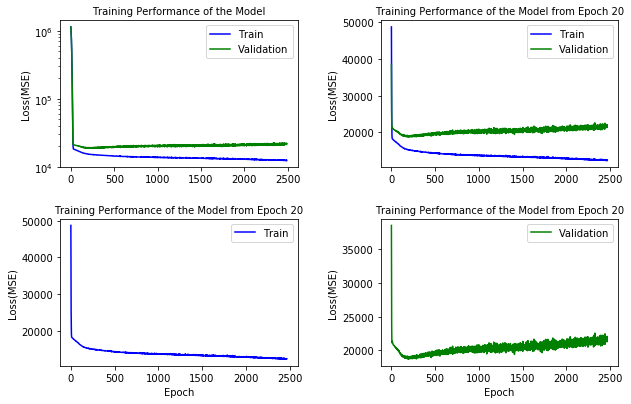

In [5]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)